In [9]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [10]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0 -0.110405 -0.110405  1 -0.519868 -0.630273
1  0.572214  0.572214  1 -0.741279 -0.169064
2 -1.500644 -1.500644  1  1.430615 -0.070029
3  1.804640  1.804640  0  1.037467  1.037467
4 -0.918127 -0.918127  1  1.587578  0.669451
5  0.788755  0.788755  1  0.454631  1.243386
6 -0.575955 -0.575955  1  0.153679 -0.422276
7 -0.139170 -0.139170  0 -0.399744 -0.399744
8  0.241917  0.241917  0 -1.335360 -1.335360
9 -1.191310 -1.191310  1  0.367823 -0.823487


#### Categorical Model

In [11]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1  tau  Z   epsilon         Y
0 -0.096236    0  0 -1.202483 -1.202483
1  1.674707    1  0 -0.725378 -0.725378
2  0.080764    1  1 -0.095717  0.904283
3  0.438950    1  0 -0.131766 -0.131766
4  0.614386    1  1 -0.181466  0.818534
5  0.654411    1  1 -0.243768  0.756232
6 -0.041921    0  1 -0.402926 -0.402926
7 -1.428484    0  0  0.972661  0.972661
8 -0.969787    0  0 -1.568697 -1.568697
9  0.698268    1  0  1.090373  1.090373


#### Assigning variables for econml metalearner functions

In [12]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

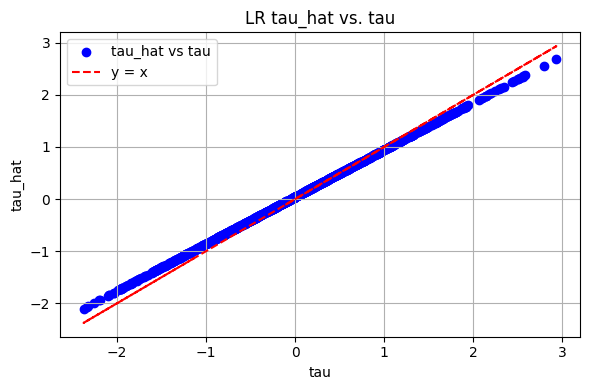

In [13]:
data['X1*Z'] = data['X1'] * data['Z'] #Setting interaction term
lr_xfit = data[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [21]:
print(tau_hat_lr)

0     -0.056945
1      0.559231
2     -1.311865
3      1.671698
4     -0.786047
         ...   
995   -0.063546
996    1.456973
997   -0.459252
998    0.227353
999   -0.968643
Name: X1, Length: 1000, dtype: float64


In [14]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.010903141159831991
Bias: -0.041387300085913625
R2 0.9887599821945404


## X-Learner

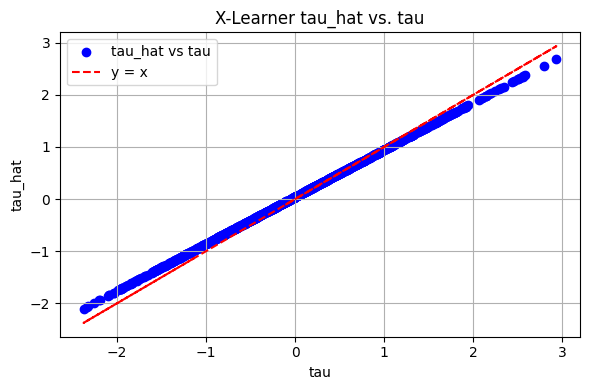

In [15]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)

mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [16]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.010903141159831993
Bias: -0.04138730008591336
R2 0.9887599821945404


## DR-Learner

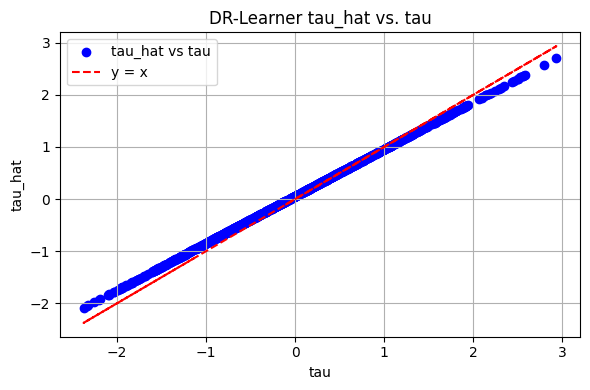

In [17]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [18]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.012208069018432686
Bias: -0.0540956156663047
R2 0.9874147357054326


## Causal Forest

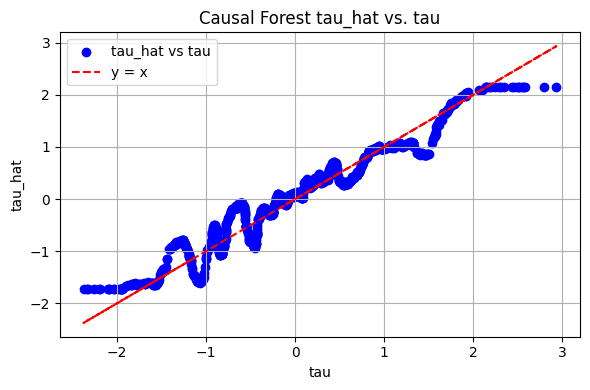

In [19]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [20]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.06463425426731387
Bias: -0.032891254576674765
R2 0.9333687275843358
